# ML Problem: Will a person suffer from human trafficking?

# 1. Libraries & Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from minisom import MiniSom
import umap
from sklearn.manifold import TSNE

In [2]:
# data loading
df = pd.read_csv('Data/human_trafficking.csv')
df.head()

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_72926/276243428.py:2: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/human_trafficking.csv')


,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [3]:
# -99 are considered mising values (NaN), so we convert them for easier handling
df.replace('-99', np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

# 2. EDA

In [4]:
df.shape

(48801, 63)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      48801 non-null  int64  
 1   Datasource                              48801 non-null  object 
 2   gender                                  48801 non-null  object 
 3   ageBroad                                36439 non-null  object 
 4   majorityStatus                          36439 non-null  object 
 5   majorityStatusAtExploit                 9290 non-null   object 
 6   majorityEntry                           6491 non-null   object 
 7   citizenship                             48523 non-null  object 
 8   meansOfControlDebtBondage               2496 non-null   float64
 9   meansOfControlTakesEarnings             3997 non-null   float64
 10  meansOfControlRestrictsFinancialAccess  253 non-null    fl

In [6]:
df.isnull().sum()

yearOfRegistration                      0
Datasource                              0
gender                                  0
ageBroad                            12362
majorityStatus                      12362
                                    ...  
recruiterRelationIntimatePartner     8807
recruiterRelationFriend              8807
recruiterRelationFamily              8807
recruiterRelationOther               8807
recruiterRelationUnknown               77
Length: 63, dtype: int64

#### some preprocessing

In [7]:
# First, replace problematic cases like '48+' with a proper range
df['ageBroad_clean'] = df['ageBroad'].str.replace(r'\+$', '--122', regex=True)

# Now safely split and convert
df[['age_min', 'age_max']] = df['ageBroad_clean'].str.split('--', expand=True).astype(float)

# Optional: drop helper column
df.drop(columns=['ageBroad_clean'], inplace=True)


## 2.1 Feature Analysis

### 2.1.0 Time & Source Information

#### yearOfRegistration: we have to drop it before training the models since the year in which victims could have been after the event that we're predicting (we're avoiding data leakage)

In [8]:
print(df[['yearOfRegistration']].info())
print(df['yearOfRegistration'].describe())
print(df[['yearOfRegistration']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   yearOfRegistration  48801 non-null  int64
dtypes: int64(1)
memory usage: 381.4 KB
None
count    48801.000000
mean      2014.144218
std          4.025566
min       2002.000000
25%       2013.000000
50%       2016.000000
75%       2017.000000
max       2019.000000
Name: yearOfRegistration, dtype: float64
yearOfRegistration    0
dtype: int64


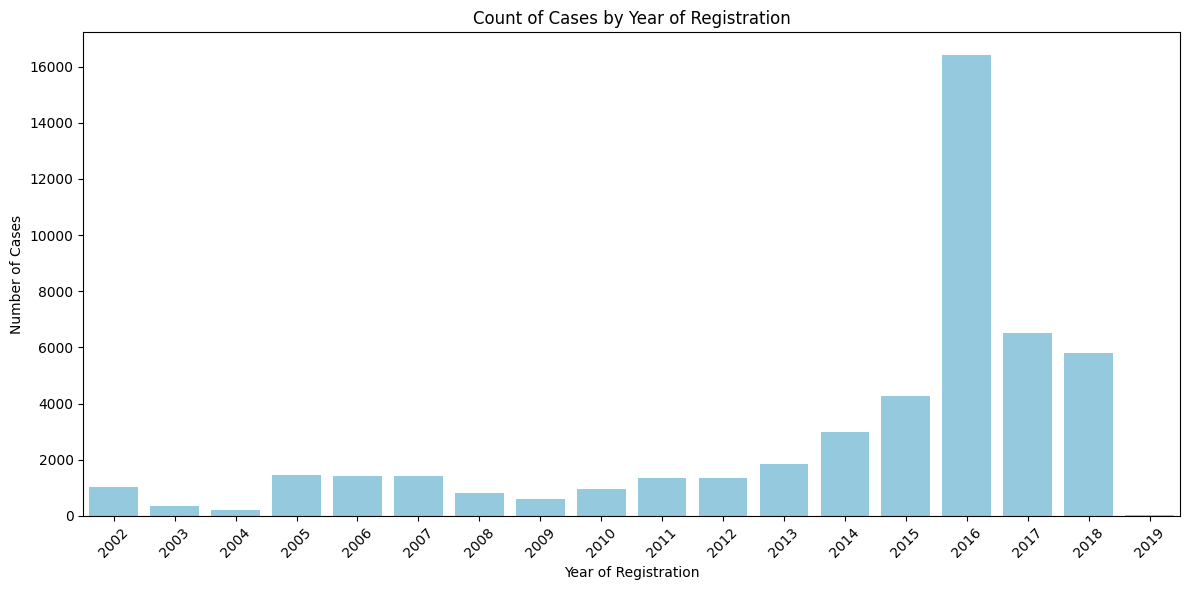

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', color='skyblue') 
plt.title("Count of Cases by Year of Registration")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*** from this we can get that 2016 was the golden year of human trafficking (maybe some event triggered it? Some social event? crisis? migrations?).It could be also a backlog of cases being officially registered that year Also the recent years are more prominent, but 2019 is too low after all that peak maybe they didnt collect the whole year data. 

In [10]:
# Exploitation features to visualize
exploitation_features = [
    'isForcedLabour', 'isSexualExploit', 'isOtherExploit', 'isSexAndLabour', 
    'isForcedMarriage', 'isForcedMilitary', 'isOrganRemoval', 'isSlaveryAndPractices'
]

# Melt the dataframe to long format
df_melted = df[['yearOfRegistration'] + exploitation_features].melt(id_vars='yearOfRegistration', 
                                                                     var_name='ExploitType', 
                                                                     value_name='Presence')

# Filter rows where Presence is 1 (indicating the presence of the exploit type)
df_melted = df_melted[df_melted['Presence'] == 1]

# Aggregate counts by year and exploit type
df_aggregated = df_melted.groupby(['yearOfRegistration', 'ExploitType']).size().reset_index(name='Count')

# Create an interactive Plotly bar chart
fig = px.bar(df_aggregated, 
             x="yearOfRegistration", 
             y="Count", 
             color="ExploitType", 
             barmode="stack",
             title="Trends in Exploitation Types by Year of Registration",
             labels={"yearOfRegistration": "Year of Registration", "Count": "Number of Cases"},
             height=600)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Number of Cases",
    xaxis=dict(tickangle=45),
    barmode='stack',  # Stack bars to show the trend for each type of exploitation
)

# Show the plot
fig.show()


Early years: Sexual Exploitation > Forced Labour
Mid-years: Growth in Forced Labour
2016: Huge rise in Other Exploitation (plus new types appear)
After 2016: Sexual Exploitation dominates again, but dataset becomes more diverse in types.

All of this is affected by the lack of good data collection mentioned previosuly

In [49]:
# Sexual exploitation features to visualize
sexual_exploitation_features = [
    'typeOfSexProstitution', 'typeOfSexPornography', 'typeOfSexRemoteInteractiveServices', 'typeOfSexPrivateSexualServices'
]

# Melt the dataframe to long format
df_melted_sexual = df[['yearOfRegistration'] + sexual_exploitation_features].melt(id_vars='yearOfRegistration', 
                                                                                   var_name='ExploitType', 
                                                                                   value_name='Presence')

# Filter rows where Presence is 1 (indicating the presence of the exploit type)
df_melted_sexual = df_melted_sexual[df_melted_sexual['Presence'] == 1]

# Aggregate counts by year and exploit type
df_aggregated_sexual = df_melted_sexual.groupby(['yearOfRegistration', 'ExploitType']).size().reset_index(name='Count')

# Create an interactive Plotly bar chart
fig_sexual = px.bar(df_aggregated_sexual, 
                    x="yearOfRegistration", 
                    y="Count", 
                    color="ExploitType", 
                    barmode="stack",
                    title="Trends in Sexual Exploitation Types by Year of Registration",
                    labels={"yearOfRegistration": "Year of Registration", "Count": "Number of Cases"},
                    height=600)

# Update layout for better readability
fig_sexual.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Number of Cases",
    xaxis=dict(tickangle=45),
    barmode='stack',  # Stack bars to show the trend for each type of exploitation
)

# Show the plot
fig_sexual.show()




In [46]:
# Labor exploitation features to visualize
labor_exploitation_features = [
    'typeOfLabourAgriculture', 'typeOfLabourAquafarming', 'typeOfLabourBegging', 'typeOfLabourConstruction',
    'typeOfLabourDomesticWork', 'typeOfLabourHospitality', 'typeOfLabourIllicitActivities', 'typeOfLabourManufacturing',
    'typeOfLabourMiningOrDrilling', 'typeOfLabourPeddling', 'typeOfLabourTransportation', 'typeOfLabourOther'
]

# Melt the dataframe to long format
df_melted_labor = df[['yearOfRegistration'] + labor_exploitation_features].melt(id_vars='yearOfRegistration', 
                                                                                 var_name='ExploitType', 
                                                                                 value_name='Presence')

# Filter rows where Presence is 1 (indicating the presence of the exploit type)
df_melted_labor = df_melted_labor[df_melted_labor['Presence'] == 1]

# Aggregate counts by year and exploit type
df_aggregated_labor = df_melted_labor.groupby(['yearOfRegistration', 'ExploitType']).size().reset_index(name='Count')

# Create an interactive Plotly bar chart
fig_labor = px.bar(df_aggregated_labor, 
                   x="yearOfRegistration", 
                   y="Count", 
                   color="ExploitType", 
                   barmode="stack",
                   title="Trends in Labor Exploitation Types by Year of Registration",
                   labels={"yearOfRegistration": "Year of Registration", "Count": "Number of Cases"},
                   height=600)

# Update layout for better readability
fig_labor.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Number of Cases",
    xaxis=dict(tickangle=45),
    barmode='stack',  # Stack bars to show the trend for each type of exploitation
)

# Show the plot
fig_labor.show()


In [11]:

# List of recruiter columns
recruiter_cols = [
    'recruiterRelationIntimatePartner', 'recruiterRelationFriend', 
    'recruiterRelationFamily', 'recruiterRelationOther', 'recruiterRelationUnknown'
]

# Group by yearOfRegistration and calculate the mean for each recruiter type
recruiter_trends = df.groupby('yearOfRegistration')[recruiter_cols].mean().reset_index()

# Create an interactive line plot using Plotly
fig = px.line(recruiter_trends, 
              x='yearOfRegistration', 
              y=recruiter_cols, 
              title="Trends in Recruiter Relationship Over Time",
              labels={"yearOfRegistration": "Year of Registration", "value": "Proportion of Cases"},
              line_shape='linear',  # Linear line connection
              markers=True,         # Show markers for each point
              height=600)

# Update layout for better aesthetics and readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Proportion of Cases",
    xaxis=dict(tickangle=45),
    legend_title="Recruiter Relationship",
    legend=dict(title="Recruiter Relationship", x=1, y=1)
)

# Show the plot
fig.show()


** In most of the cases we don't know their relationship with the recluiter, prob victims often don't know or don't report who recruited them. This aligns with the other known relationships, since when unknown no relationship and the opposite happens. It starts to know from 2011 this could be bc in those years data collection was poor. Most of the type of relationships are not mentioned in the features that we have in the dataset. from 2011 to 2016 friend relation and family relation are prominent while from 2014 the intimate partner relation increases having its peak in 2018.

- Trafficking is often conducted by trusted people like relatives or partners, not just strangers.
- Trust-based relationships (family, partners, friends) are increasingly used as a method to exploit and traffic individuals.

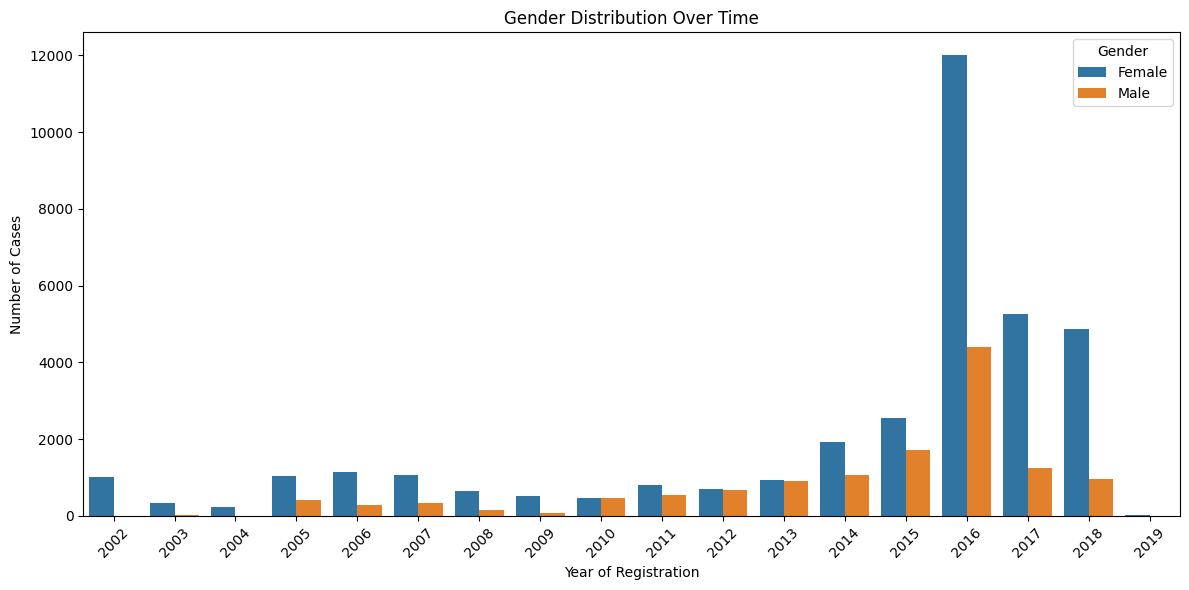

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', hue='gender')
plt.title("Gender Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

Females are consistently the majority.
Male victim reporting increases from 2010 onward.
2016 shows a historic peak for both genders, but females still dominate (huge difference)

The spike in human trafficking cases, especially after 2010, was likely caused by better reporting, expanded legal definitions to include forced labour and other exploitations, and major global migration crises. These changes also led to more visibility of male victims, although females remained the majority

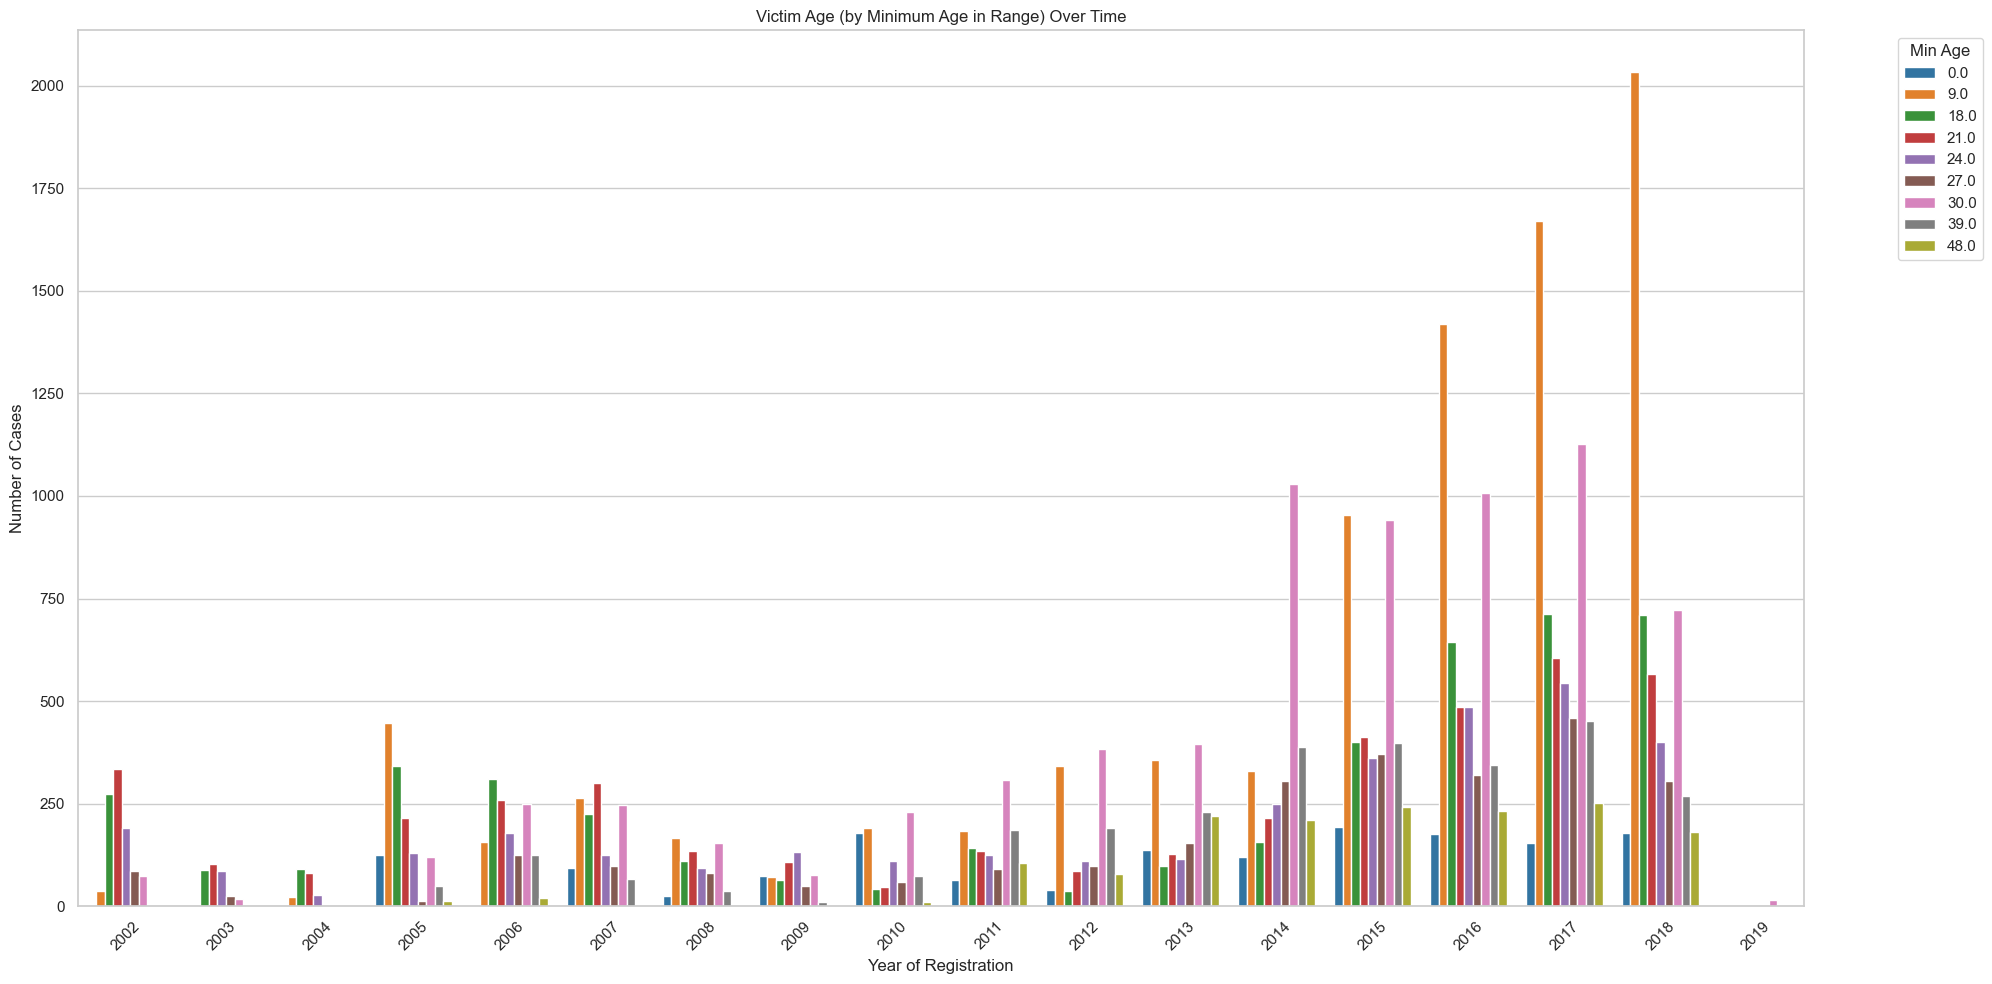

In [44]:
plt.figure(figsize=(20, 10))
sns.countplot(
    data=df.dropna(subset=['age_min']),
    x='yearOfRegistration',
    hue='age_min',
    palette='tab10'
)
plt.title("Victim Age (by Minimum Age in Range) Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Min Age", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



victims aged 9–17 increasingly became the largest group in human trafficking cases, especially after 2014, suggesting a worrying rise in child exploitation. Adult groups (18–38) also grew, but at a slower pace compared to minors

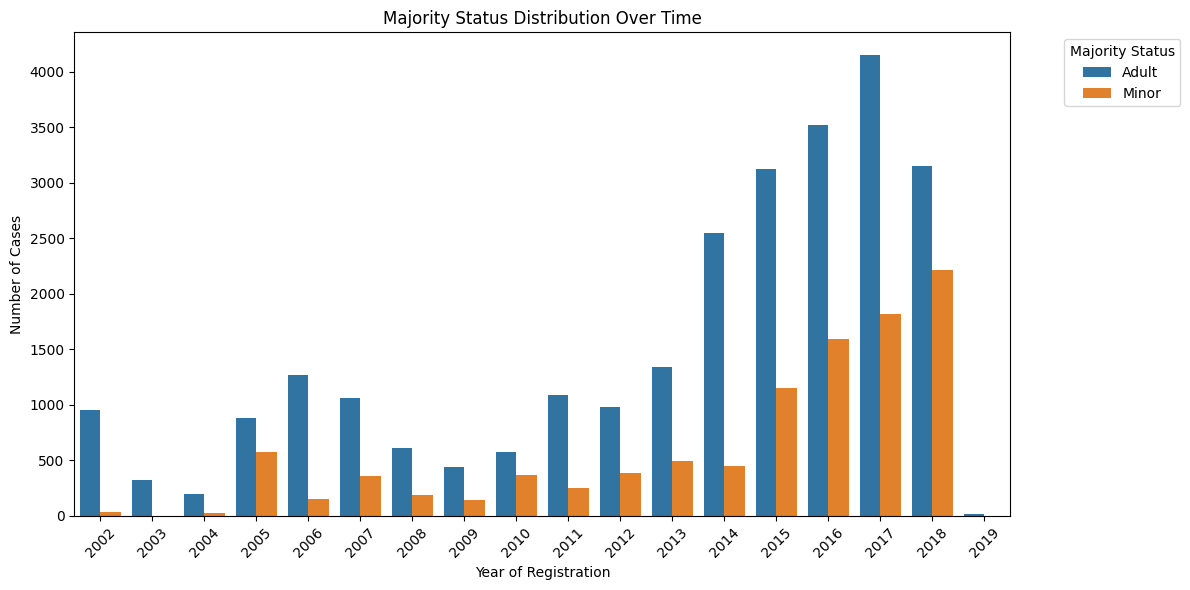

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityStatus']), x='yearOfRegistration', hue='majorityStatus')
plt.title("Majority Status Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

even though it contradicts previous comments, it is reasonable that adults cases are highers since the range of age is bigger than minors.

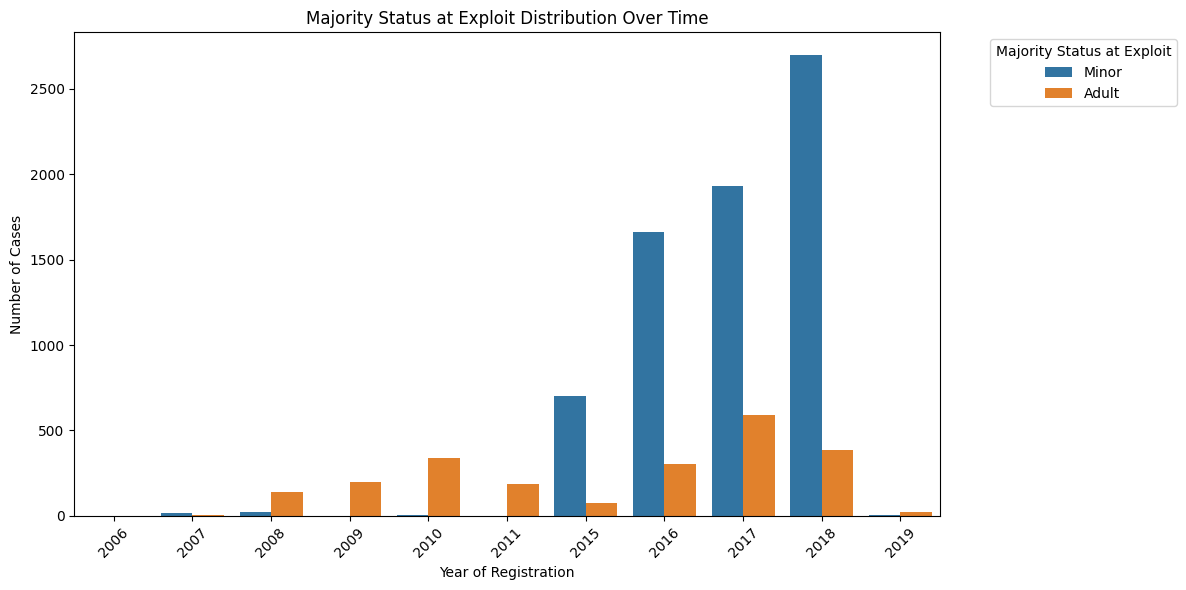

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityStatusAtExploit']), x='yearOfRegistration', hue='majorityStatusAtExploit')
plt.title("Majority Status at Exploit Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Status at Exploit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

** this is weird. why are more minors at the time of exploitation if when trafficked there were more adults? some people were trafficked when they were adults, but others were trafficked when they were kids and even if fewer kids were trafficked at first, they stayed trapped for longer and got exploited more.
Also, after a while, traffickers started focusing more on minors because they were easier to control and there was more demand

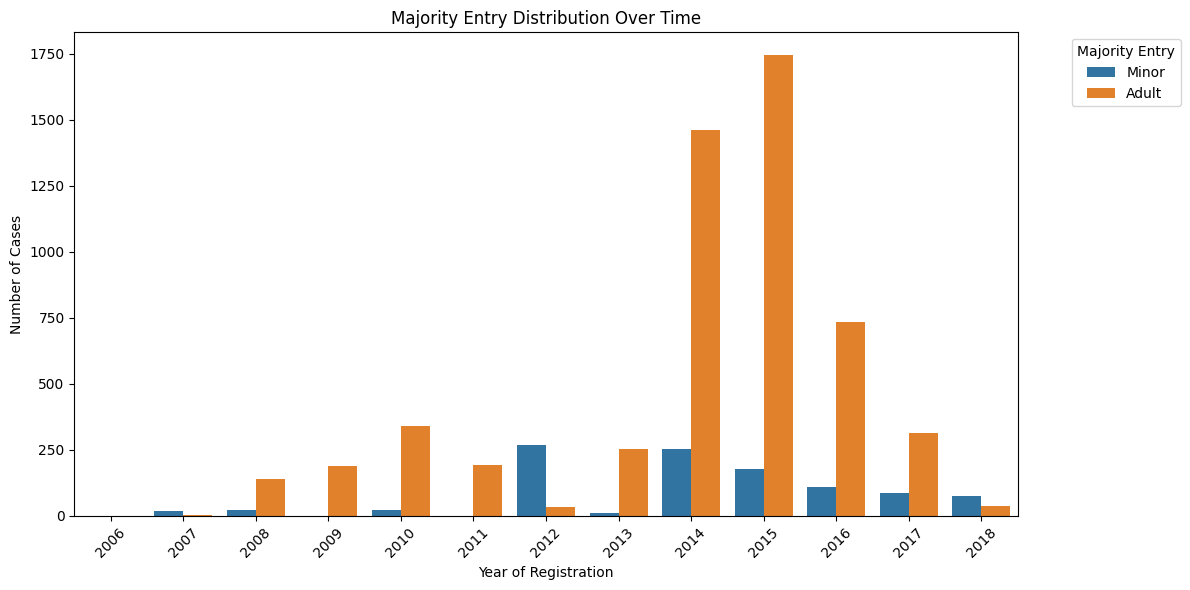

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityEntry']), x='yearOfRegistration', hue='majorityEntry')
plt.title("Majority Entry Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Entry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

fewer cases than it should. why at the entry there so little but for the normal distributions theres way. however the distirbution seems pretty similar despite the lack of info.

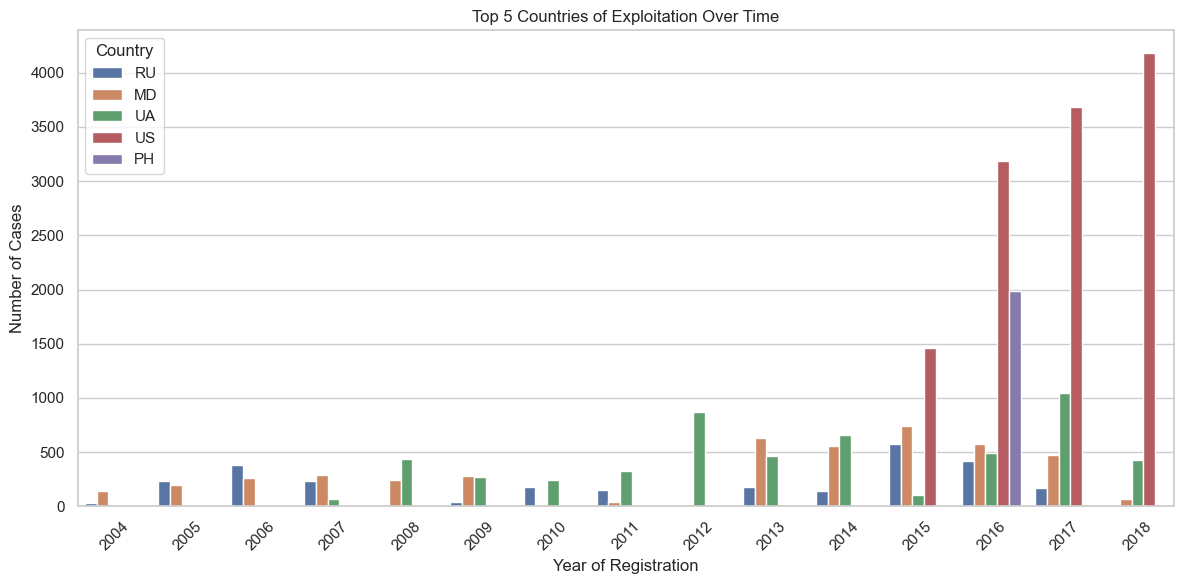

In [41]:
top_countries = df['CountryOfExploitation'].value_counts().head(5).index.tolist()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['CountryOfExploitation'].isin(top_countries)], 
              x='yearOfRegistration', hue='CountryOfExploitation')
plt.title("Top 5 Countries of Exploitation Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Country")
plt.tight_layout()
plt.show()


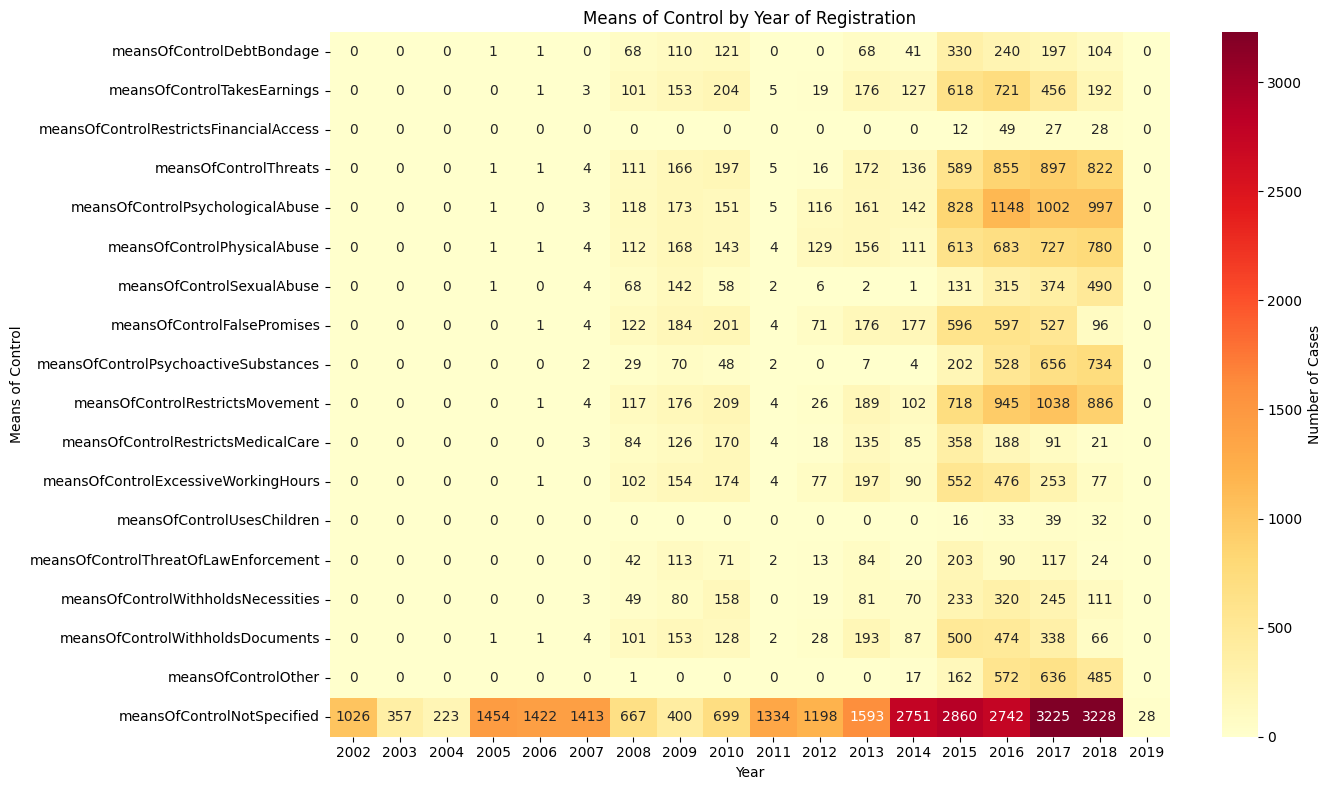

In [18]:
means_of_control_cols = [
    'meansOfControlDebtBondage',
    'meansOfControlTakesEarnings',
    'meansOfControlRestrictsFinancialAccess',
    'meansOfControlThreats',
    'meansOfControlPsychologicalAbuse',
    'meansOfControlPhysicalAbuse',
    'meansOfControlSexualAbuse',
    'meansOfControlFalsePromises',
    'meansOfControlPsychoactiveSubstances',
    'meansOfControlRestrictsMovement',
    'meansOfControlRestrictsMedicalCare',
    'meansOfControlExcessiveWorkingHours',
    'meansOfControlUsesChildren',
    'meansOfControlThreatOfLawEnforcement',
    'meansOfControlWithholdsNecessities',
    'meansOfControlWithholdsDocuments',
    'meansOfControlOther',
    'meansOfControlNotSpecified'
]

# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(yearly.T, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Number of Cases'})
plt.title('Means of Control by Year of Registration')
plt.xlabel('Year')
plt.ylabel('Means of Control')
plt.tight_layout()
plt.show()






After 2013, there was a sharp rise in recorded human trafficking cases, especially for Psychological Abuse, Threats, Restricts Movement, and Excessive Working Hours, which became the most prominent means of control; this likely reflects improved reporting practices, legal changes, or greater awareness. Earlier years mostly recorded "Not Specified" means of control, and the sudden drop in 2019 likely indicates incomplete data collection mentioned previously.

##### more detailed code for means of control for each year of registration

In [19]:
# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum().reset_index()

# Create traces for each control
fig = go.Figure()

for control in means_of_control_cols:
    fig.add_trace(
        go.Bar(x=yearly['yearOfRegistration'], y=yearly[control], name=control, visible=False)
    )

# Make first one visible
fig.data[0].visible = True

# Dropdown buttons
buttons = []
for i, control in enumerate(means_of_control_cols):
    visible = [False] * len(means_of_control_cols)
    visible[i] = True
    buttons.append(
        dict(label=control,
             method='update',
             args=[{'visible': visible},
                   {'title': f'Means of Control: {control}'}])
    )

# Layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.05)],
    title='Means of Control: ' + means_of_control_cols[0],
    xaxis_title='Year of Registration',
    yaxis_title='Number of Cases'
)

fig.show()



** maybe for amjority status i have to check it's not redundant with the age range, cuz maybe we have to drop it since its repeptitive information.

#### Datasource: biased feature we have to drop before the model

In [20]:
df[['Datasource']].info()
df['Datasource'].value_counts()
df[['Datasource']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Datasource  48801 non-null  object
dtypes: object(1)
memory usage: 381.4+ KB


Datasource    0
dtype: int64

Case Management System (CMS)
These are formal systems used by NGOs, government agencies, shelters, etc., to manage cases of victims they are helping.
How CMS can affect the data:
- More Detailed Data: Trained professionals collect structured information, often after spending time with the victim.
- Cross-checked: Case workers can verify details (like age, citizenship) by asking follow-up questions.

- Bias Toward Detected Victims: CMS usually records only people who have already been rescued or identified. Not hidden cases.
- Longer Time Gap: Cases might get registered months or even years after trafficking happened → affects things like registrationYear.
- Formal definitions: They follow strict definitions of trafficking, so some gray area cases may be excluded.

Example of affected features: registrationYear, majorityEntry, ageBroad, meansOfControl

Hotline Reports
Hotlines are anonymous or semi-anonymous tip lines where victims or witnesses call in.
How Hotline data can affect the data:
- Real-time Reporting: You get very fresh data — closer to when the trafficking is happening.
- More Diverse Cases: Includes hidden populations who would not go to authorities.

- Incomplete Data: People may only give partial info ("I saw a girl being forced to work") → missing values.
- More Unverified: It's hard to confirm what really happened from just a call.
- Misclassification Risk: A caller might mistake a bad labor practice for trafficking, or vice versa.

Example of affected features:
countryOfExploitation, typeOfExploitation, recruiterRelation, meansOfControl, ageBroad

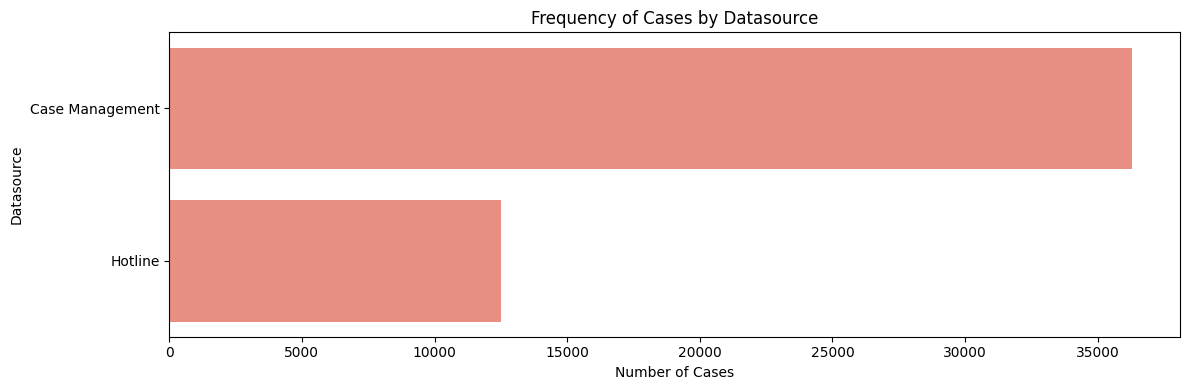

In [21]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, y='Datasource', order=df['Datasource'].value_counts().index, color='salmon')
plt.title("Frequency of Cases by Datasource")
plt.xlabel("Number of Cases")
plt.ylabel("Datasource")
plt.tight_layout()
plt.show()

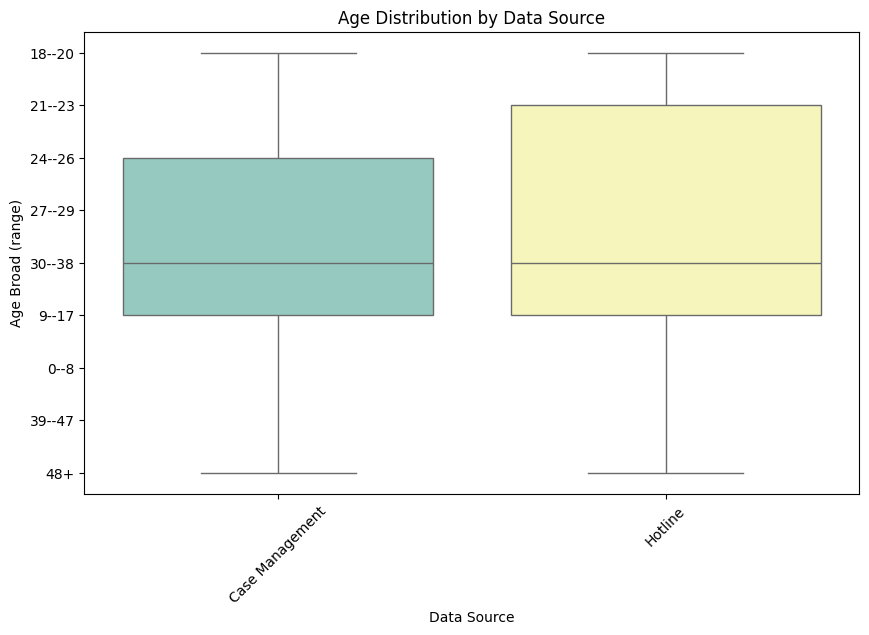

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Datasource', y='ageBroad', hue='Datasource', palette='Set3', legend=False)
plt.title('Age Distribution by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Age Broad (range)')
plt.xticks(rotation=45)
plt.show()


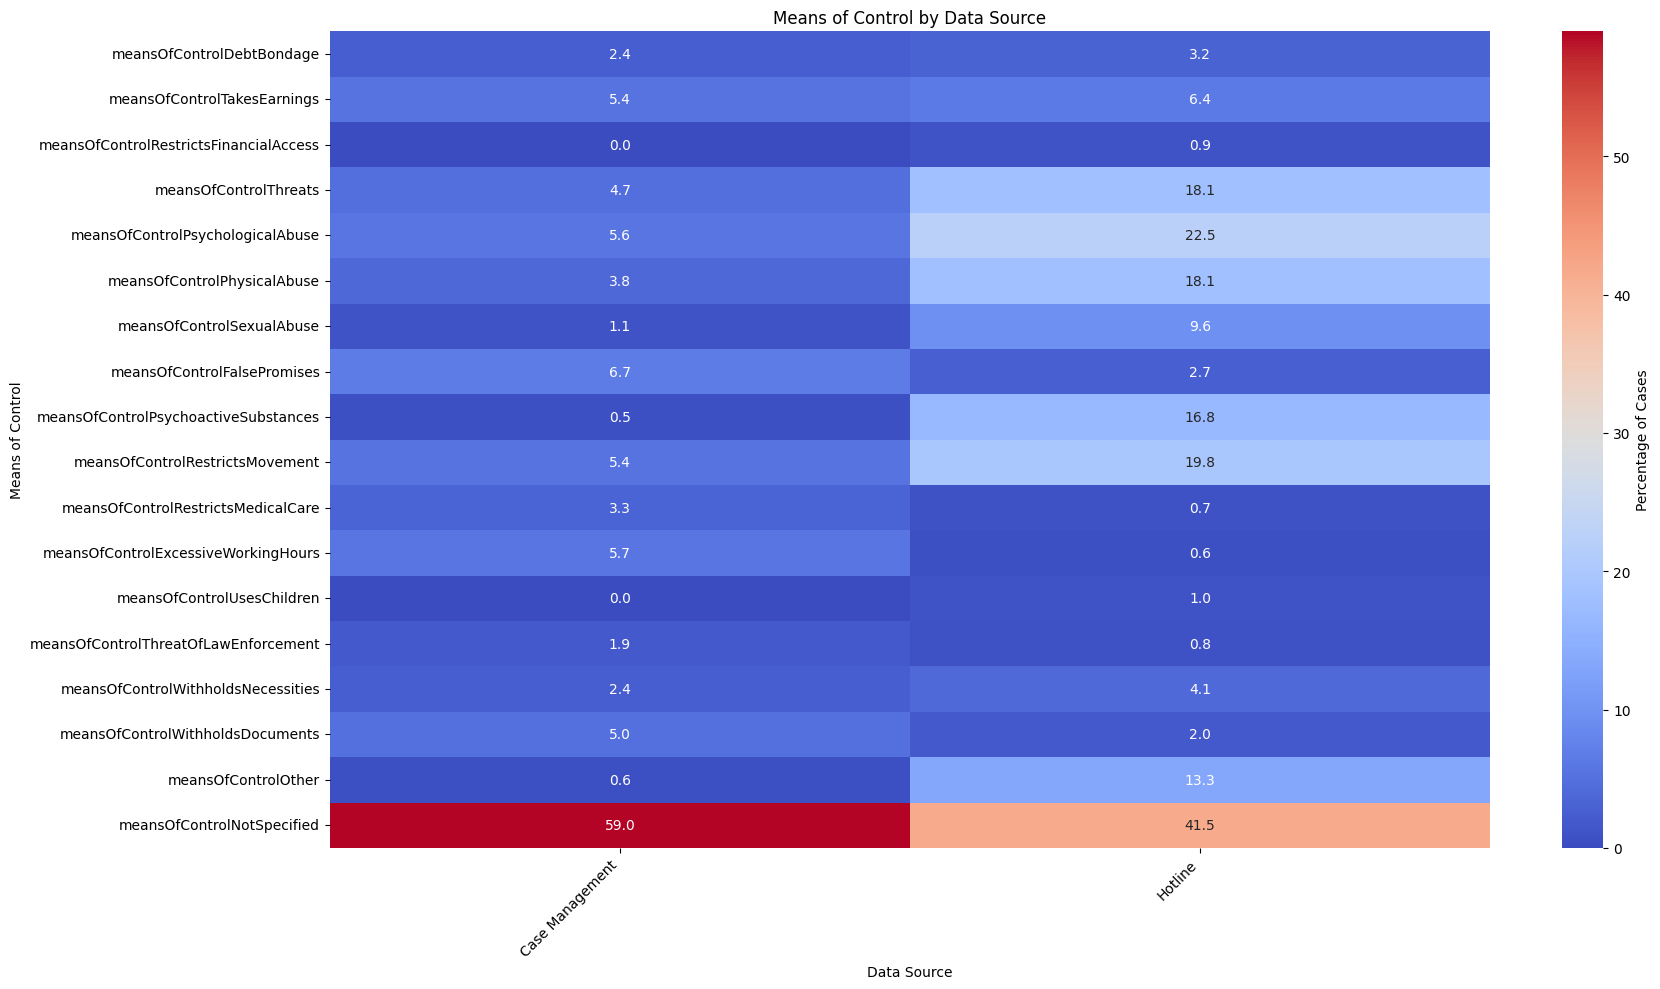

In [23]:
# Count how many cases exist per datasource
source_counts = df['Datasource'].value_counts()

# Now calculate the correct percentage for each means of control
heatmap_data = {}

for control in means_of_control_cols:
    counts = df.groupby('Datasource')[control].sum()  # Sum where control was 1
    percentages = counts / source_counts * 100         # Calculate % over total cases in that source
    heatmap_data[control] = percentages

# Create a DataFrame
heatmap_df = pd.DataFrame(heatmap_data).T  # transpose to get controls as rows

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Percentage of Cases'})
plt.title('Means of Control by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Means of Control')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 2.1.1 Victim Demographics

### 2.1.2 Type of Exploitation

### 2.1.3 Type of Labour

### 2.1.4 Type of Sexual Exploitation

### 2.1.5 Types of Recuiter Relationship and Country of Exploitation

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# Optional: Set plotting style
sns.set(style="whitegrid")


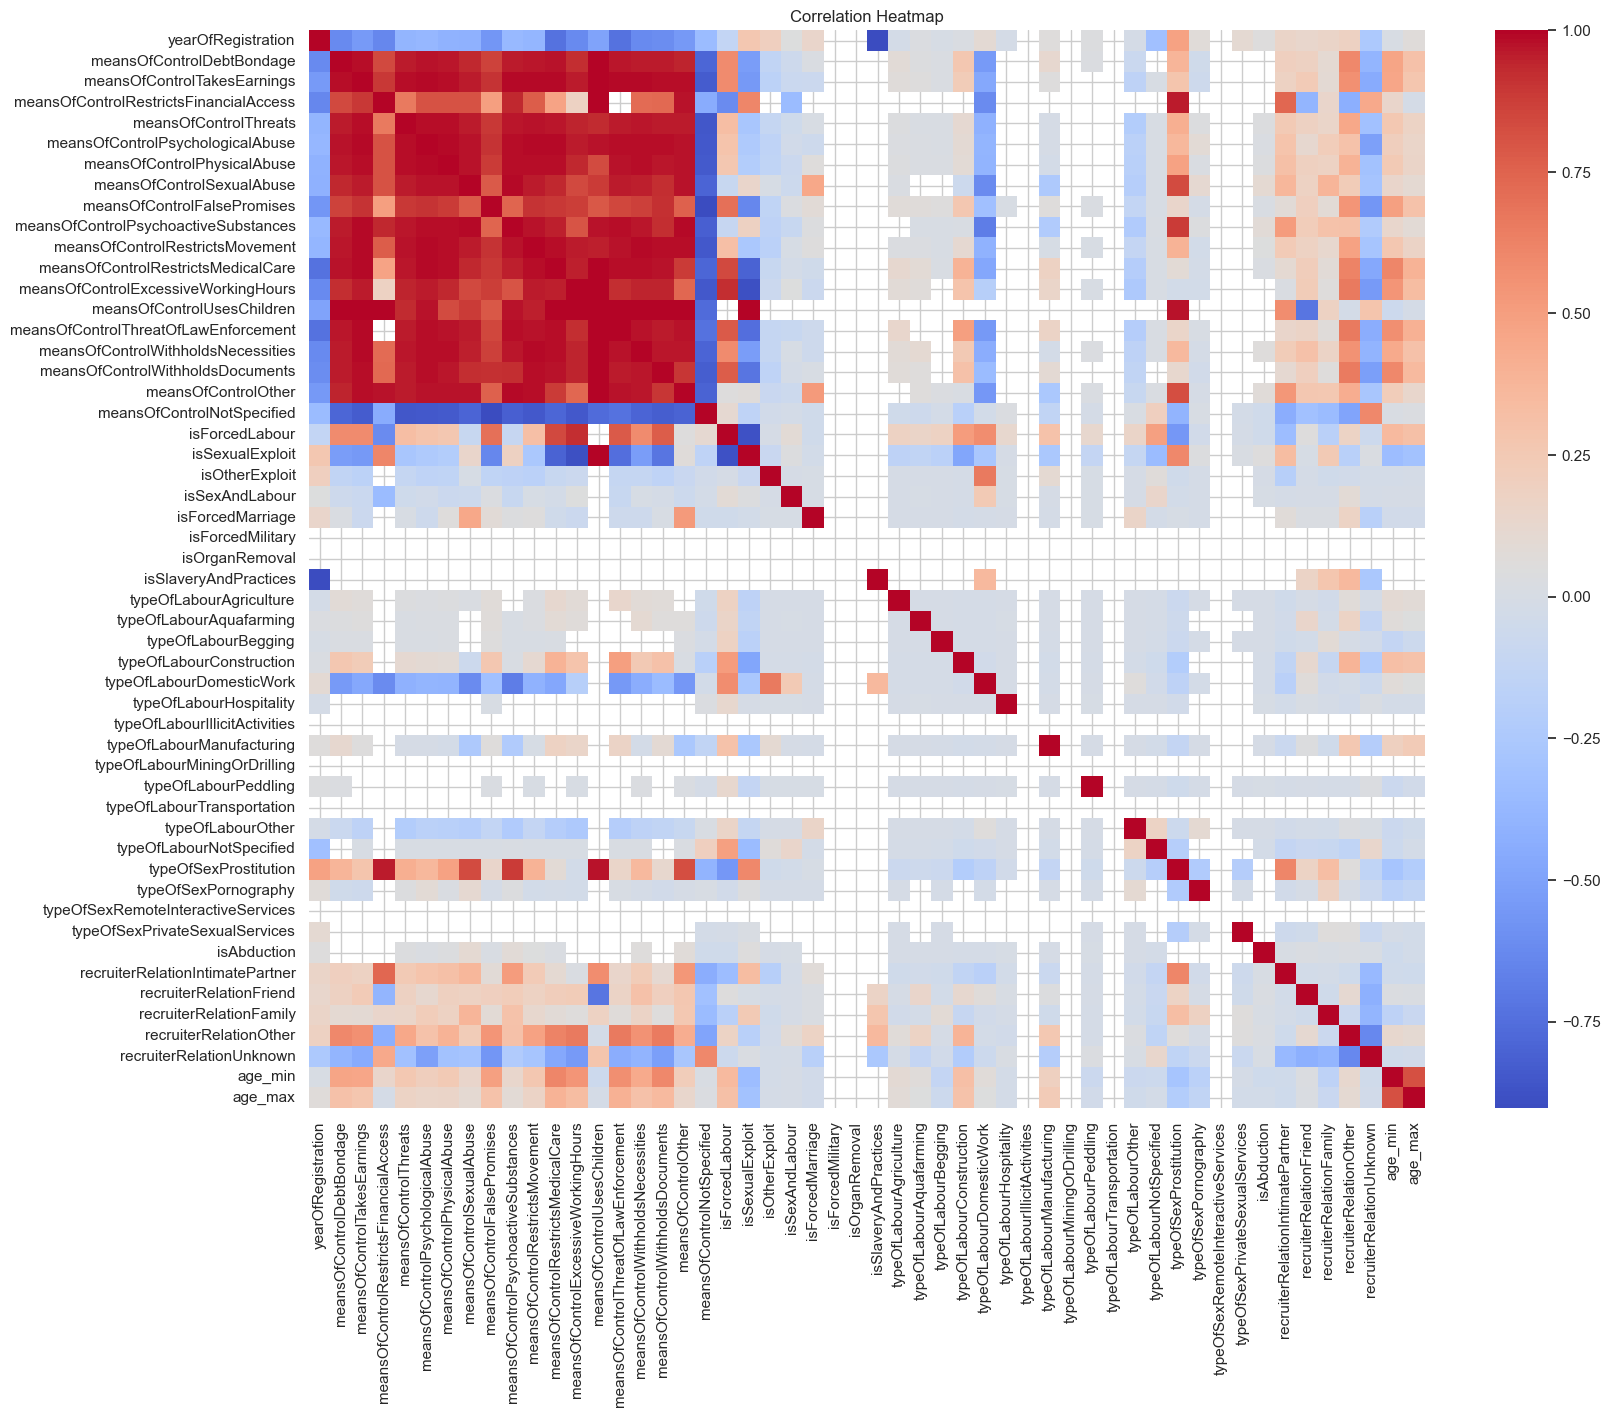

In [25]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


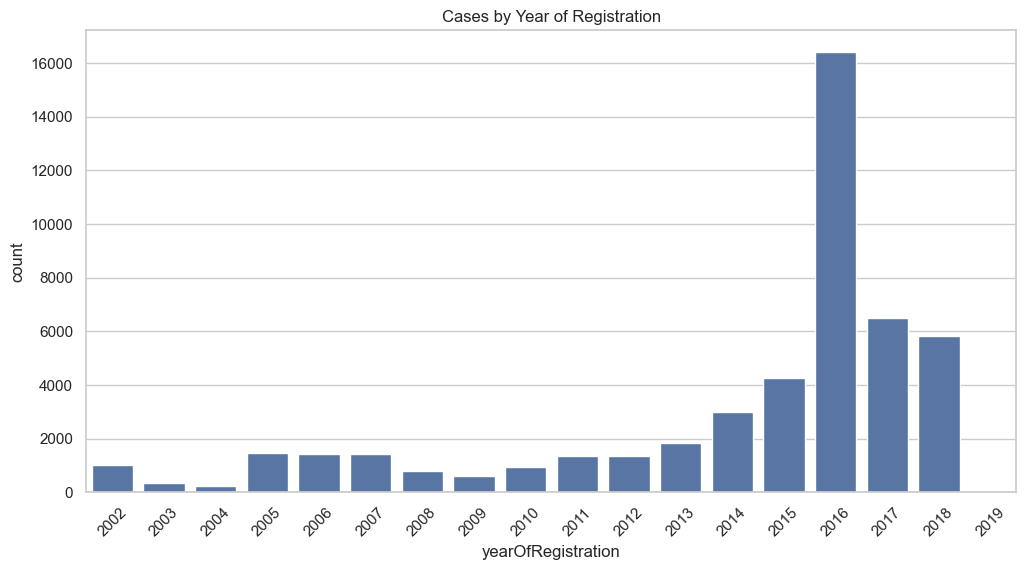

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='yearOfRegistration', data=df, order=sorted(df['yearOfRegistration'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Cases by Year of Registration")
plt.show()


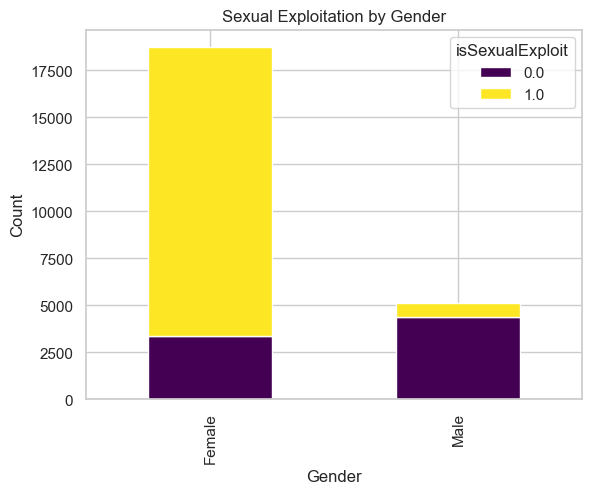

In [27]:
cross_tab = pd.crosstab(df['gender'], df['isSexualExploit'])
cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sexual Exploitation by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(title='isSexualExploit')
plt.show()


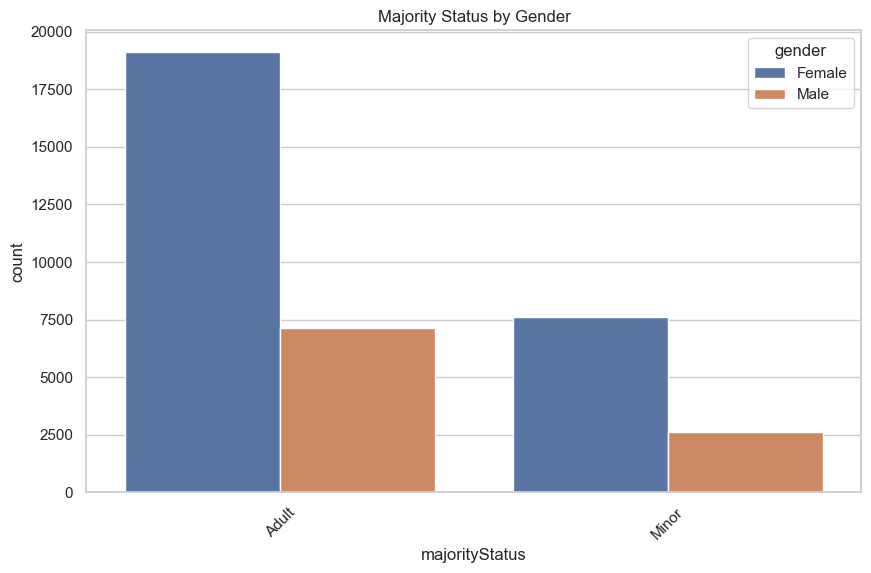

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='majorityStatus', hue='gender')
plt.title("Majority Status by Gender")
plt.xticks(rotation=45)
plt.show()


In [29]:
%pip install pycountry


Note: you may need to restart the kernel to use updated packages.


In [30]:
import pycountry
import plotly.express as px

# Create a mapping from ISO alpha-2 codes to full country names
def code_to_country(code):
    try:
        if pd.isna(code) or code == '00':
            return 'Unknown'
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Apply the mapping
df['citizenship_country'] = df['citizenship'].apply(code_to_country)

# Count occurrences
country_counts = df['citizenship_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Cases by Citizenship Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [31]:
country_counts = df['CountryOfExploitation'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Exploitation Cases by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [32]:
subset = df[['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']].dropna().copy()
subset = subset[subset['typeOfExploitConcatenated'] != '']

subset = subset.groupby(['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']).size().reset_index(name='count')

# Create node list
all_nodes = pd.concat([
    subset['gender'],
    subset['typeOfExploitConcatenated'],
    subset['CountryOfExploitation']
]).unique().tolist()

# Map node labels to index
label_to_idx = {label: idx for idx, label in enumerate(all_nodes)}

# Create links
source = subset['gender'].map(label_to_idx)
target = subset['typeOfExploitConcatenated'].map(label_to_idx)
middle_target = subset['CountryOfExploitation'].map(label_to_idx)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=subset['count']
    )
)])

fig.update_layout(title_text="Sankey Diagram: Gender → Type of Exploitation", font_size=10)
fig.show()


# 3. Handling Missing Values

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_72926/3255378421.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




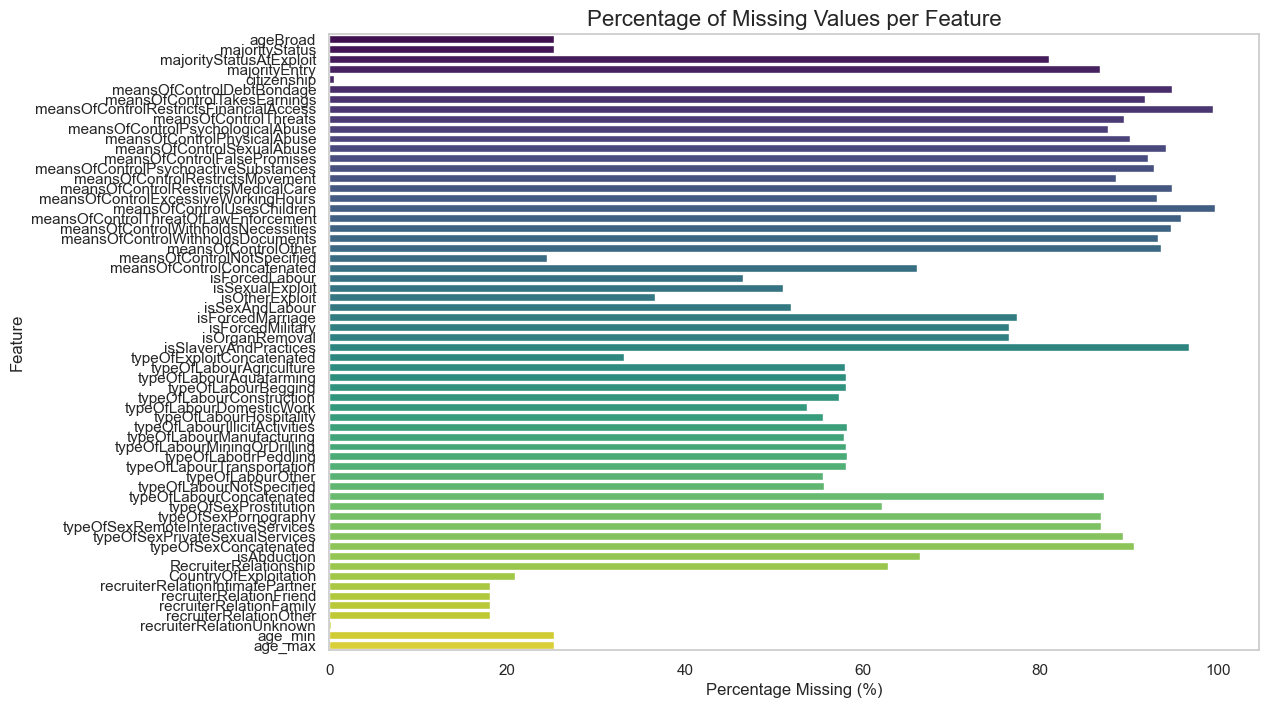

In [33]:
# 1. Calculate missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Keep only columns with missing values
missing_percentage = (missing_values / len(df)) * 100

# 2. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
plt.title('Percentage of Missing Values per Feature', fontsize=16)
plt.xlabel('Percentage Missing (%)')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()


#Apporach to be  determined

#Lots of features have a 1 or a 0 or -99 and -99 can be swapped out with 0 if we want


# 4. Outliers

# 5. Data Partitioning (Split)

# 6. Feature Engineering and Scaling

## 6.2 Feature engineering and scaling for unsupervised learning

In [34]:
# 1. Handling Missing Values
X = df.copy()


# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values for categorical columns
X[categorical_cols] = X[categorical_cols].fillna('Unknown')  # 'Unknown' for categorical variables

# Fill missing values for numerical columns
X[numerical_cols] = X[numerical_cols].fillna(0)  # 0 for numerical variables (or you could use median/mean)

In [35]:
# 2. Encoding Categorical 
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical columns
X_encoded = ohe.fit_transform(X[categorical_cols])

# Create new column names for the encoded features
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# Convert to DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols)

# Drop original categorical columns and concatenate with encoded ones
X = pd.concat([X.drop(columns=categorical_cols), X_encoded_df], axis=1)

In [36]:
# 3. Scaling the Features (Important for Clustering Algorithms)

# Standardize features by scaling the data to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the dataset

In [37]:
# If you wish to reduce dimensionality later (optional), use PCA
pca = PCA(n_components=2)  # Reducing to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

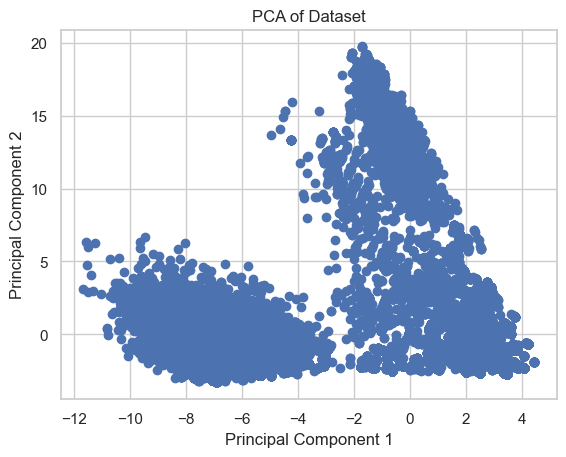

In [38]:
# Optional: Visualize the data after PCA transformation (useful for high-dimensional data)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 7. Model Selection

## 7.1 Baseline Model

In [39]:
# Assume X_scaled is your preprocessed data (scaled features)

# Initialize the KMeans model (you can adjust the number of clusters based on your problem)
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the KMeans model to the scaled data
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Calculate performance metrics
silhouette = silhouette_score(X_scaled, clusters_kmeans)
davies_bouldin = davies_bouldin_score(X_scaled, clusters_kmeans)
calinski_harabasz = calinski_harabasz_score(X_scaled, clusters_kmeans)

# Store results in a dictionary
performance_metrics = {
    "KMeans": {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    }
}

# Print the performance metrics for KMeans
print("Performance for KMeans:")
for metric, value in performance_metrics["KMeans"].items():
    print(f"  {metric}: {value:.4f}")


KeyboardInterrupt: 

In [ ]:
# Optional: Convert the performance metrics into a DataFrame for easy visualization
metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df)

        Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
KMeans          0.320324               0.48749                43.385379


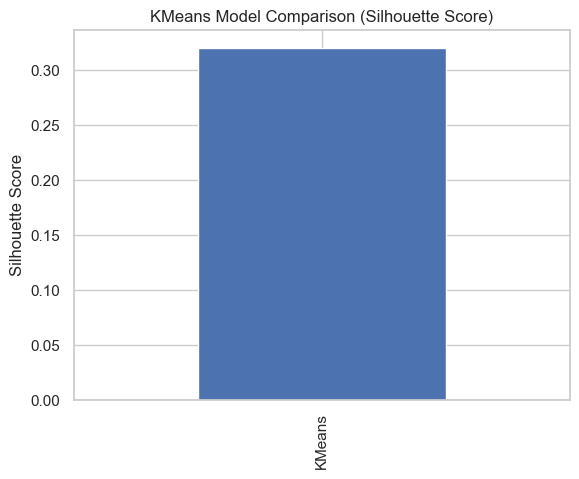

In [ ]:
# Now you can optionally plot the Silhouette Score for KMeans
metrics_df['Silhouette Score'].plot(kind='bar', title="KMeans Model Comparison (Silhouette Score)")
plt.ylabel("Silhouette Score")
plt.show()

## 7.2 Model 1

In [ ]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Since DBSCAN might label some points as noise (-1), let's ignore them for metric calculations
clusters_dbscan_cleaned = clusters_dbscan[clusters_dbscan != -1]
X_scaled_cleaned = X_scaled[clusters_dbscan != -1]

# Calculate performance metrics
silhouette_dbscan = silhouette_score(X_scaled_cleaned, clusters_dbscan_cleaned)
davies_bouldin_dbscan = davies_bouldin_score(X_scaled_cleaned, clusters_dbscan_cleaned)
calinski_harabasz_dbscan = calinski_harabasz_score(X_scaled_cleaned, clusters_dbscan_cleaned)

# Store results in the dictionary
performance_metrics["DBSCAN"] = {
    "Silhouette Score": silhouette_dbscan,
    "Davies-Bouldin Index": davies_bouldin_dbscan,
    "Calinski-Harabasz Index": calinski_harabasz_dbscan
}

# Print the performance metrics for DBSCAN
print("\nPerformance for DBSCAN:")
for metric, value in performance_metrics["DBSCAN"].items():
    print(f"  {metric}: {value:.4f}")



Performance for DBSCAN:
  Silhouette Score: 0.9290
  Davies-Bouldin Index: 0.0746
  Calinski-Harabasz Index: 102579.5287


## 7.3 Model 2

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Initialize AgglomerativeClustering with cosine affinity
agg_clustering = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')

# Fit the AgglomerativeClustering model
clusters_agg = agg_clustering.fit_predict(X_pca)

# Calculate performance metrics
silhouette_agg = silhouette_score(X_pca, clusters_agg)
davies_bouldin_agg = davies_bouldin_score(X_pca, clusters_agg)
calinski_harabasz_agg = calinski_harabasz_score(X_pca, clusters_agg)

# Store results in the dictionary
performance_metrics["Agglomerative Clustering"] = {
    "Silhouette Score": silhouette_agg,
    "Davies-Bouldin Index": davies_bouldin_agg,
    "Calinski-Harabasz Index": calinski_harabasz_agg
}

# Print the performance metrics for Agglomerative Clustering
print("\nPerformance for Agglomerative Clustering:")
for metric, value in performance_metrics["Agglomerative Clustering"].items():
    print(f"  {metric}: {value:.4f}")


## 7.4 Model 3

In [ ]:
# Initialize Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)

# Fit the GMM model
clusters_gmm = gmm.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_gmm = silhouette_score(X_scaled, clusters_gmm)
davies_bouldin_gmm = davies_bouldin_score(X_scaled, clusters_gmm)
calinski_harabasz_gmm = calinski_harabasz_score(X_scaled, clusters_gmm)

# Store results in the dictionary
performance_metrics["Gaussian Mixture Model"] = {
    "Silhouette Score": silhouette_gmm,
    "Davies-Bouldin Index": davies_bouldin_gmm,
    "Calinski-Harabasz Index": calinski_harabasz_gmm
}

# Print the performance metrics for GMM
print("\nPerformance for Gaussian Mixture Model:")
for metric, value in performance_metrics["Gaussian Mixture Model"].items():
    print(f"  {metric}: {value:.4f}")



Performance for Gaussian Mixture Model:
  Silhouette Score: 0.3203
  Davies-Bouldin Index: 0.4875
  Calinski-Harabasz Index: 43.3854


## 7.5 Model 4

In [ ]:
# Assuming X_scaled is your scaled data
# 7. Self-Organizing Maps (SOM) - Clustering
som = MiniSom(5, 5, X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.train(X_scaled, 10000, verbose=True)

# Extracting SOM labels by finding the winning node for each sample
som_labels = np.array([som.winner(x)[0] * 5 + som.winner(x)[1] for x in X_scaled])

# Performance Metrics
performance_metrics = {}
performance_metrics["Self-Organizing Map"] = {
    "Silhouette Score": silhouette_score(X_scaled, som_labels),
    "Davies-Bouldin Index": davies_bouldin_score(X_scaled, som_labels),
    "Calinski-Harabasz Index": calinski_harabasz_score(X_scaled, som_labels)
}

print(performance_metrics)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 25.59135818466459
{'Self-Organizing Map': {'Silhouette Score': np.float64(0.4543558075345541), 'Davies-Bouldin Index': np.float64(2.075438437390221), 'Calinski-Harabasz Index': np.float64(28.831671568304174)}}


## Visualizations

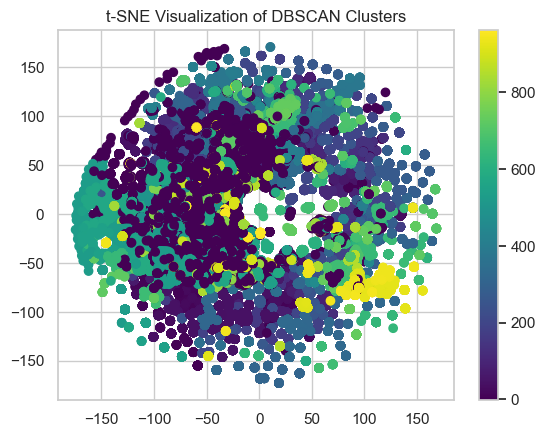

In [ ]:
# 5. t-SNE Visualization (not clustering, only for visualization)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.show()

## Summary

In [ ]:
# Combine all results into the performance_metrics dictionary
performance_metrics = {
    "KMeans": {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    },
    "DBSCAN": {
        "Silhouette Score": silhouette_dbscan,
        "Davies-Bouldin Index": davies_bouldin_dbscan,
        "Calinski-Harabasz Index": calinski_harabasz_dbscan
    },
    "Agglomerative Clustering": {
        "Silhouette Score": silhouette_agg,
        "Davies-Bouldin Index": davies_bouldin_agg,
        "Calinski-Harabasz Index": calinski_harabasz_agg
    },
    "Gaussian Mixture Model": {
        "Silhouette Score": silhouette_gmm,
        "Davies-Bouldin Index": davies_bouldin_gmm,
        "Calinski-Harabasz Index": calinski_harabasz_gmm
    },
    "Self-Organizing Map": {
        "Silhouette Score": silhouette_score(X_scaled, som_labels),
        "Davies-Bouldin Index": davies_bouldin_score(X_scaled, som_labels),
        "Calinski-Harbasz Index": calinski_harabasz_score(X_scaled, som_labels)
    }
}

# Convert the dictionary into a DataFrame for easy visualization
metrics_df = pd.DataFrame(performance_metrics).T
print("\nPerformance Comparison of Models:")
print(metrics_df)


Performance Comparison of Models:
                          Silhouette Score  Davies-Bouldin Index  \
KMeans                            0.320324              0.487490   
DBSCAN                            0.928993              0.074553   
Agglomerative Clustering         -0.128201              6.703841   
Gaussian Mixture Model            0.320324              0.487490   
Self-Organizing Map               0.454356              2.075438   

                          Calinski-Harabasz Index  Calinski-Harbasz Index  
KMeans                                  43.385379                     NaN  
DBSCAN                              102579.528670                     NaN  
Agglomerative Clustering               196.485438                     NaN  
Gaussian Mixture Model                  43.385379                     NaN  
Self-Organizing Map                           NaN               28.831672  


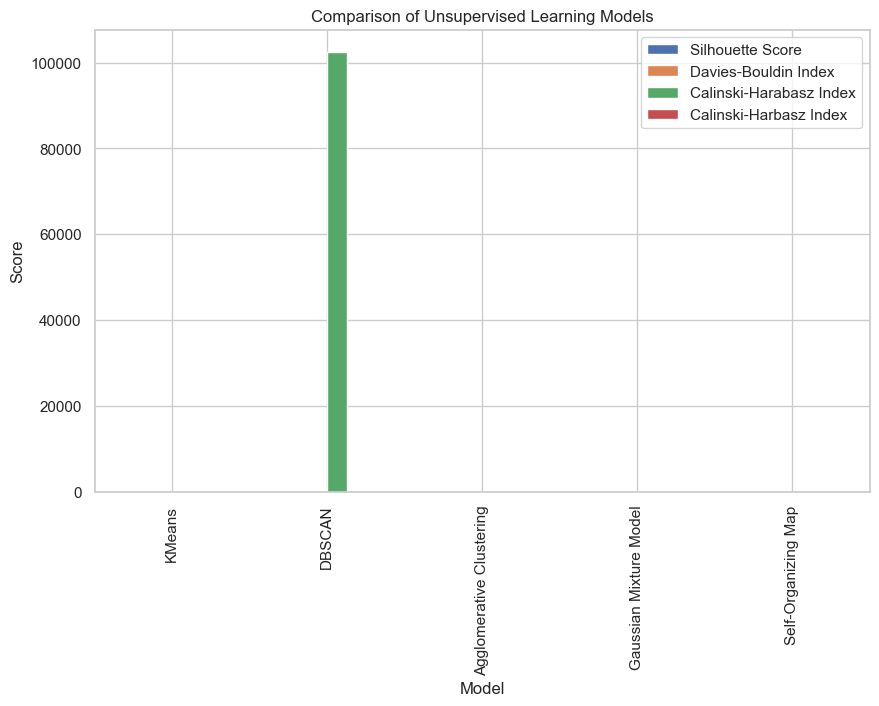

In [ ]:
# Plot the performance metrics for comparison
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Unsupervised Learning Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.show()

# 8. Model Evaluation